We have all seen fake news forwards on our WhatsApp messages. Generally, these articles are generated by bots and internet trollers and are used with an intent to intrigue the audience and mislead them. Fake news can be very dangerous as it can spread misinformation and inflict rage in public. It is now becoming a serious problem in India due to more and more people using social media and lower levels of digital awareness.



# Demo

Here's a screenrecording of the Model in action. I copied a article from a authentic and reputed news source, pasted it on the text block and ran inference. As you can see the model gave the correct prediction of the article being Real. 

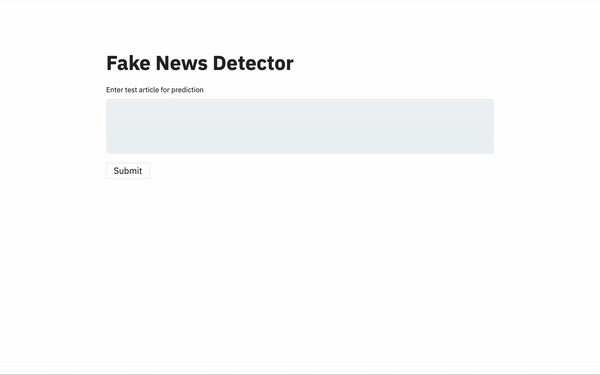


# Approach Used

Bidirectional Recurrent Neural Networks (BRNN) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously. Invented in 1997 by Schuster and Paliwal, BRNNs were introduced to increase the amount of input information available to the network. Standard recurrent neural network (RNNs) also have restrictions as the future input information cannot be reached from the current state. On the contrary, BRNNs do not require their input data to be fixed. Moreover, their future input information is reachable from the current state.

# Importing Libraries

In this notebook I'd like to continue on the work of [Atish Adhikari](https://www.kaggle.com/atishadhikari). In his [notebook](https://www.kaggle.com/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy), he proposes a novel approach for News Classification.

We'll use the following modules, 
* [numpy](https://numpy.org/doc/stable/reference/index.html)
* [pandas](https://pandas.pydata.org/docs/reference/index.html)
* [tensorflow](https://www.tensorflow.org/api_docs/python/tf)
* [tensorflow_datasets](https://www.tensorflow.org/datasets/overview?hl=en)

In [1]:
import numpy as np # For Linear Algebra
import pandas as pd # For I/O, Data Transformation
import tensorflow as tf # Tensorflow
import tensorflow_datasets as tfds # For the SubTextEncoder
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# Pre-Processing and Cleaning

The original dataset doesn't have any class variables associated with the instances. Thus, to enable supervised learning we add another "**class**" variable to the DataFrames. Also, to get a reliable and authentic score for classification we concatenate the "**text**" and "**title**" columns. We then drop the redundant columns from both the DataFrames. Then, we just make a single DataFrame out of both the DataFrames.

In [2]:
fakedataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv") # Make a DataFrame for Fake News
realdataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv") # Make a DataFrame for Real News
realdataset["class"] = 1 # Adding Class to Real News
fakedataset["class"] = 0 # Adding Class to Fake News
realdataset["text"] = realdataset["title"] + " " + realdataset["text"] # Concatenating Text and Title into a single column for Real News DataFrame
fakedataset["text"] = fakedataset["title"] + " " + fakedataset["text"] # Concatenating Text and Title into a single column for Fake News DataFrame
realdataset = realdataset.drop(["subject", "date", "title"], axis = 1) # Removing Redundant features from Real News DataFrame
fakedataset = fakedataset.drop(["subject", "date", "title"], axis = 1) # Removing Redundant features from Fake News DataFrame
dataset = realdataset.append(fakedataset, ignore_index = True) # Making a Single DataFrame 
del realdataset, fakedataset 

# Encoding the Corpus

To encode the corpus, we use the [**SubwordTextEncoder**](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder) from tfds.features.text's **build_from_corpus** function. We declare a novel vocab_size of 10,000 and then use the "**text**" column from the DataFrame.

In [3]:
vocab_size = 10000
encoder = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(dataset["text"], vocab_size)

Here, we create a function to encode the DataFrame by looping through all the sentences in the corpus, with "**post**" padding using the [**tf.keras.preprocessing.sequence.pad_sequences()**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences?hl=en) function.

In [4]:
def enc(dataframe):
    tokenized = []
    for sentence in dataframe["text"].values:
        tokenized.append(encoder.encode(sentence))
    out = tf.keras.preprocessing.sequence.pad_sequences(tokenized, padding = "post")
    return out
x = enc(dataset)

Using the "**class**" column of the Dataset for Supervised Training of the Model

In [5]:
y = dataset["class"]
print(y)

0        1
1        1
2        1
3        1
4        1
        ..
44893    0
44894    0
44895    0
44896    0
44897    0
Name: class, Length: 44898, dtype: int64


# Model Definition

Here, we define our Model with the following layers:

* [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding?hl=en)
* [Bidirectional GRU Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional?hl=en) with 64 units
* [Bidirectional GRU Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional?hl=en) with 32 units
* [Dense Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=en) with 64 units
* [Dropout Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout?hl=en) with a 50% droprate
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=en) with a single output unit

We then compile the model using:

* [Adam Optimiser](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?hl=en)
* [Binary Crossentropy Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy?hl=en)
* Metrics as [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy?hl=en)

In [6]:
# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64), # Embedding Layer using the vocab-size from encoder
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)), # Create the first Bidirectional layer with 64 LSTM units
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)), # Second Bidirectional layer witth 32 LSTM units
    tf.keras.layers.Dense(64, activation='relu'), # A Dense Layer with 64 units
    tf.keras.layers.Dropout(0.5), # 50% Dropout
    tf.keras.layers.Dense(1) # Final Dense layer with a single unit
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['acc']) # Compiling the Model

# Training the Model

We train the model for a novel 2 epochs

In [7]:
history = model.fit(x,y, epochs = 2)

Epoch 1/2
1404/1404 [==============================] - 2324s 2s/step - loss: 0.0464 - acc: 0.9817
Epoch 2/2
1404/1404 [==============================] - 2341s 2s/step - loss: 0.0019 - acc: 0.9998


# Predicting with the Model

Here, we write 2 functions to predict using the model. A pad_to_size function to pad our vectors and a sample_predict function to encode a string and predict using the model.

In [8]:
def pad_to_size(vec, size):
  zero = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

sample_pred_text = ('The movie was cool. The animation and the graphics')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.44961074]]


 # Download the Model Weights for Yourself

In [9]:
model.save('my_model.h5') 
import os
from IPython.display import FileLink
FileLink(r'my_model.h5')

/kaggle/working/my_model.h5